# FyTrans 输运方程求解 

（IDS: transport_solver_numerics ）

In [ ]:
from fytok.Tokamak import Tokamak
import pathlib
import numpy as np

input_path = pathlib.Path("../data/")

In [2]:

tokamak = Tokamak(
    f"file+iterprofiles://{next(input_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(input_path.glob('g900003*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    core_transport={"model": [{"code": {"name": "dummy"}}]},
    core_sources={"source": [{"code": {"name": "dummy"}}]},
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.995, 128),
                "control_parameters": {
                    "bvp_rms_mask": [0.96],
                    "hyper_diff": 0.0001,
                    "max_nodes": 512,
                    "verbose": 2,
                },
            },
        },
        "primary_coordinate": {"index": (index := 0), "label": r"\bar{rho}_{tor_norm}"},
        "equations": [
            # fmt: off
            {"identifier": "ion/D/density_thermal",    "boundary_condition": [2, 1]},
            {"identifier": "ion/T/density_thermal",    "boundary_condition": [2, 1]},
            {"identifier": "ion/D/temperature",        "boundary_condition": [2, 1]},
            {"identifier": "ion/T/temperature",        "boundary_condition": [2, 1]},
            {"identifier": "electrons/temperature",    "boundary_condition": [2, 1]},
            # fmt: on
        ],
    },
)

2023-11-25 11:57:36,638 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_xml
2023-11-25 11:57:37,284 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_iterprofiles
2023-11-25 11:57:37,497 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.plugins.data.plugin_geqdsk


In [3]:
tokamak.transport_solver.refresh(
    time=0.0,
    initial_value=[1.0e19, 1.0e19, 1000, 1000, 1000],
    boundary_value=[[[0.0], [2.0e19]], [[0.0], [2.0e19]], [[0.0], [1000]], [[0.0], [1000]], [[0.0], [1000]]],
)

2023-11-25 11:57:37,806 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.transport_solver_numerics.fy_trans
2023-11-25 11:57:39,194 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.equilibrium.fy_eq
2023-11-25 11:57:39,364 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.mesh.mesh_rectangular
2023-11-25 11:57:41,901 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_transport.model.dummy
2023-11-25 11:57:42,001 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module fytok.plugins.core_sources.source.dummy
2023-11-25 11:57:42,283 [   fytok]    DEBUG: /home/salmon/workspace/fytok/python/fytok/modules/Utilities.p

## 可视化计算结果和中间变量

In [4]:
from spdm.view import View as sp_view

2023-11-25 11:57:55,423 [   fytok]    DEBUG: /home/salmon/workspace/fytok/SpDM/python/spdm/utils/sp_export.py:66:sp_load_module: Load module spdm.view.view_matplotlib


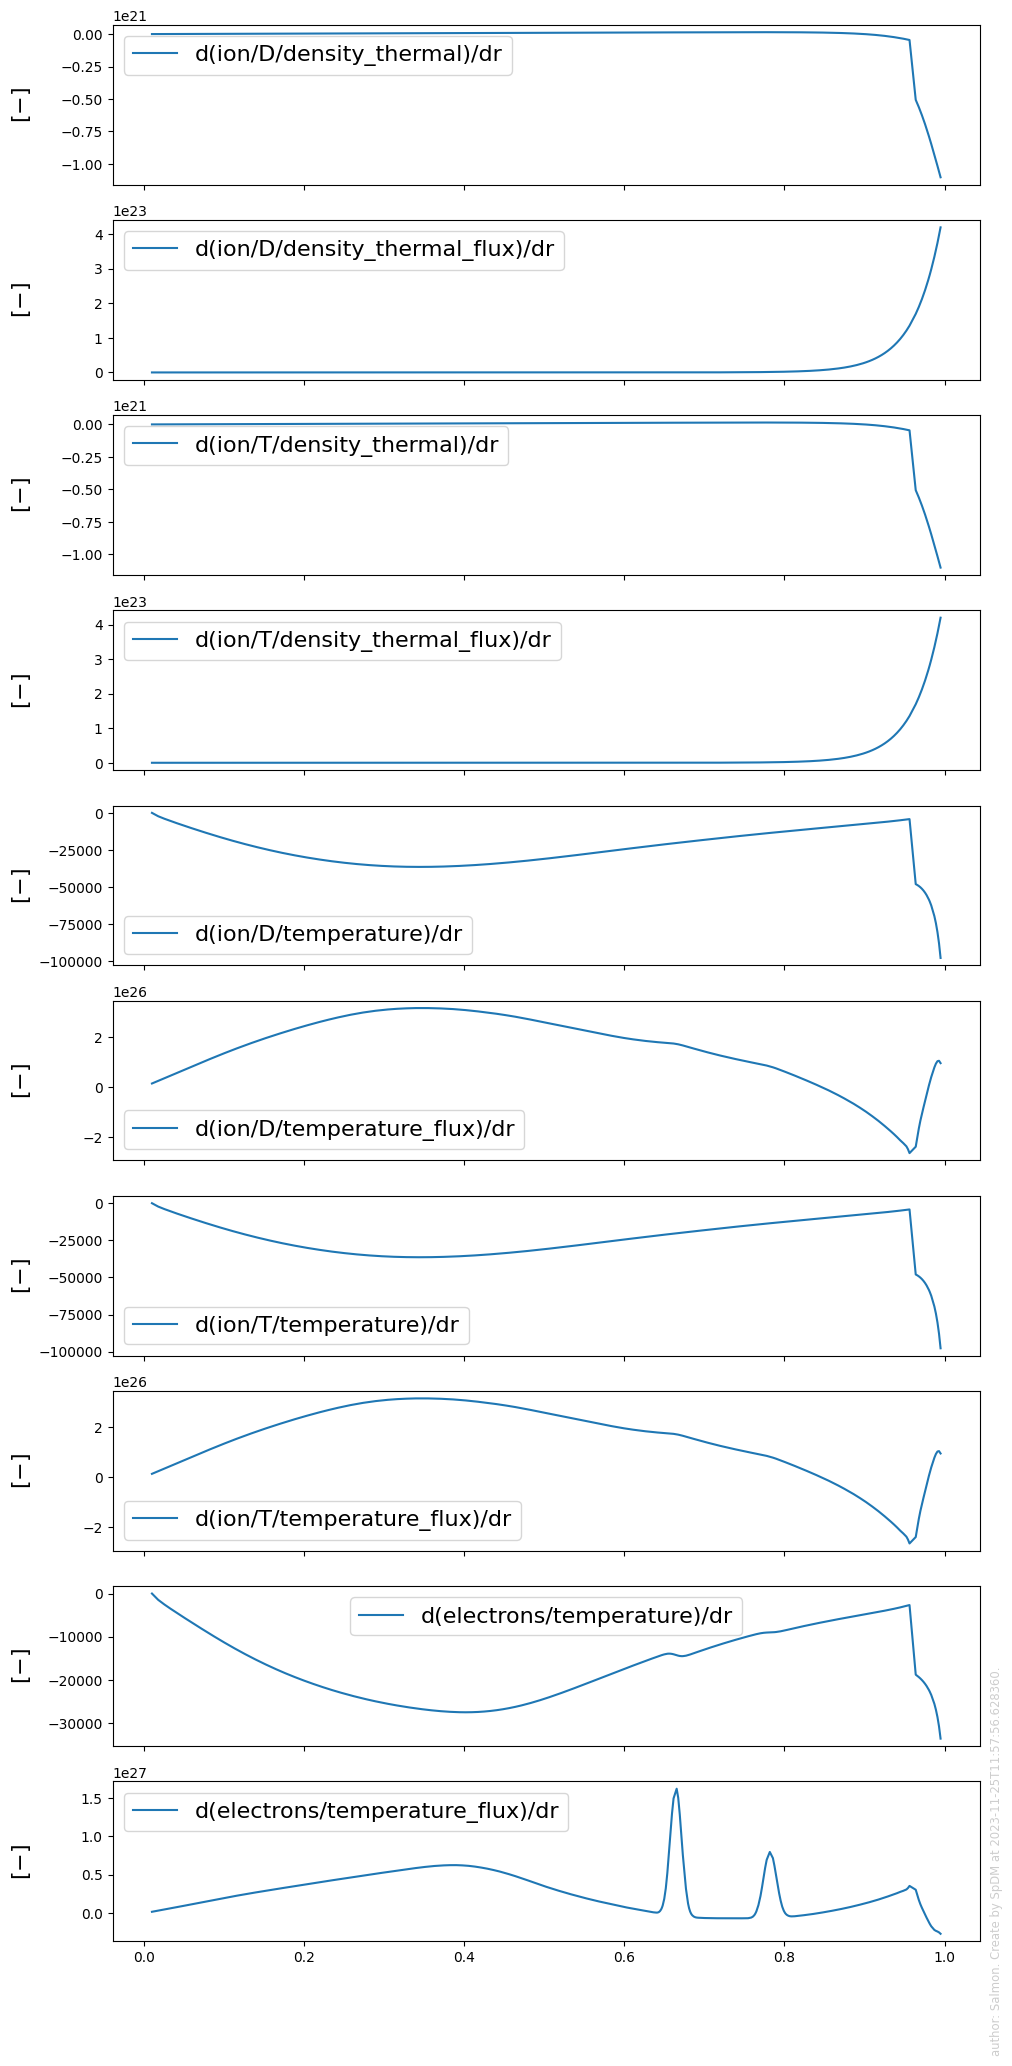

In [5]:
solver_1d = tokamak.transport_solver.time_slice.current
fig = sp_view.plot(
    sum(
        [
            [
                # (equ.primary_quantity.profile, equ.primary_quantity.identifier),
                # (equ.primary_quantity.flux, f"{equ.primary_quantity.identifier}_flux"),
                (equ.primary_quantity.d_dr,f"d({equ.primary_quantity.identifier})/dr"),
                (equ.primary_quantity.dflux_dr, f"d({equ.primary_quantity.identifier}_flux)/dr"),
            ]
            for equ in solver_1d.equation
        ],
        [],
    ),
    x_axis=solver_1d.grid.rho_tor_norm,
)

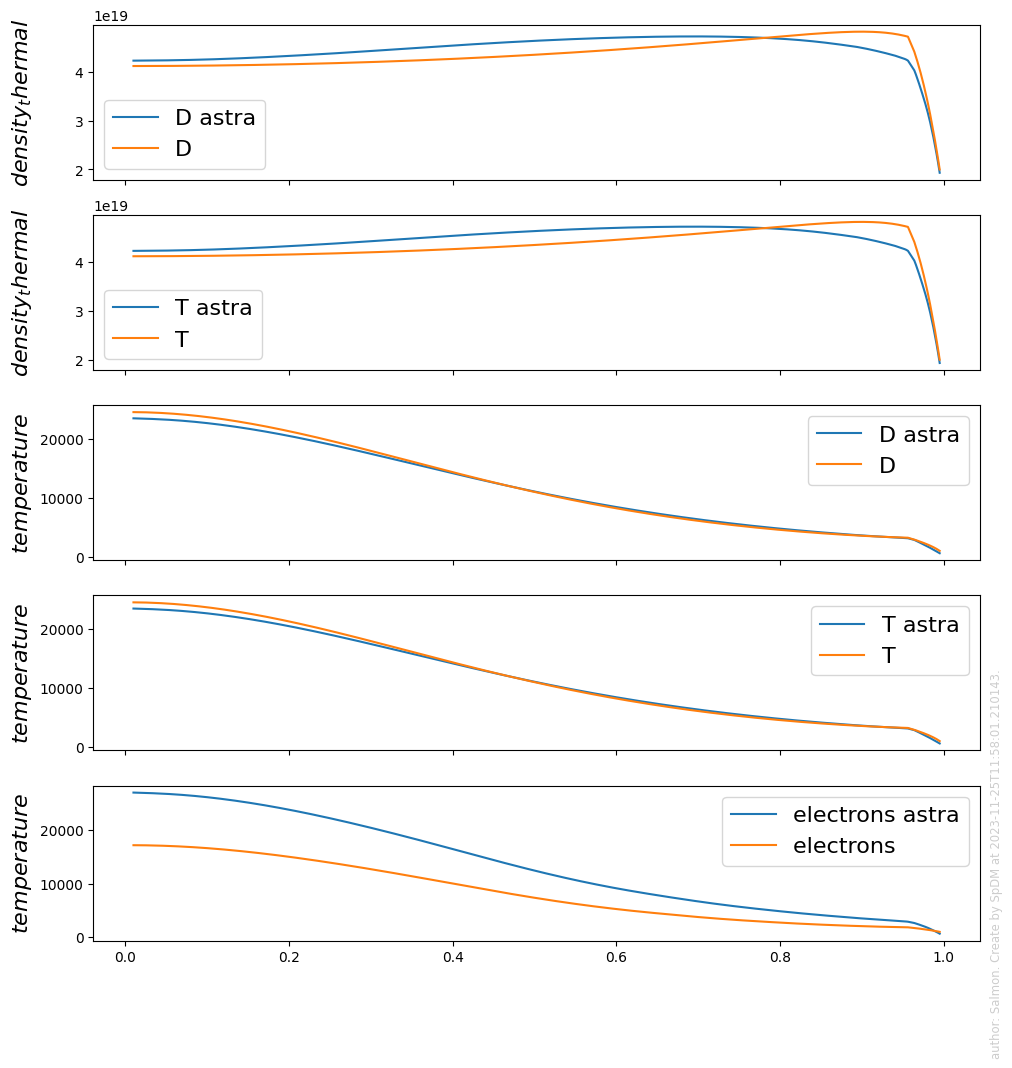

In [6]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d
fig = sp_view.plot([
    ([
        (core_profiles_1d.get(equ.primary_quantity.identifier), rf"{equ.primary_quantity.identifier.split('/')[-2]} astra"),
        (equ.primary_quantity.profile, rf"{equ.primary_quantity.identifier.split('/')[-2]} ")
    ],{"y_label": equ.primary_quantity.identifier.split("/")[-1]} ) for equ in solver_1d.equation
],
    x_axis=solver_1d.grid.rho_tor_norm
)

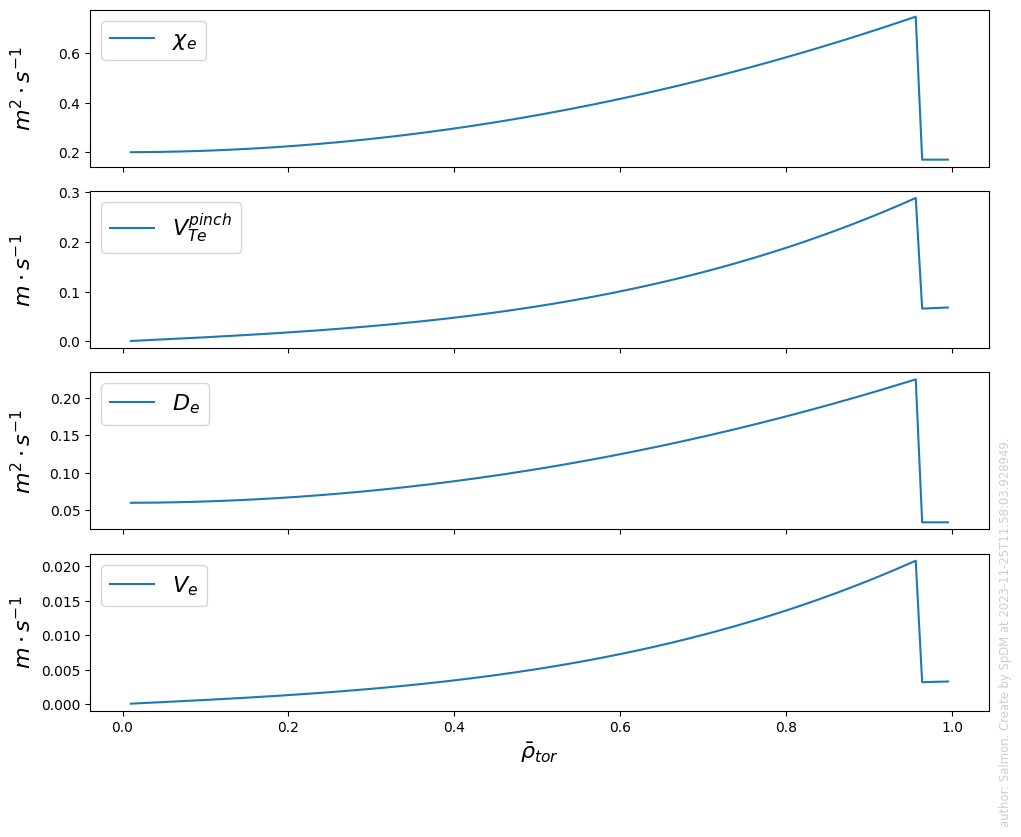

In [7]:
core_sources_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
core_transport_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d

fig = sp_view.plot(
    [
        # (core_sources_1d.electrons.energy, r"$Q_e$"),
        (core_transport_1d.electrons.energy.d, r"$\chi_e$"),
        (core_transport_1d.electrons.energy.v, r"$V^{pinch}_{Te}$"),
        # (core_sources_1d.electrons.energy_decomposed.explicit_part, r"$Q_{e}$ explicit"),
        # (core_sources_1d.electrons.energy_decomposed.implicit_part, r"$Q_{e}$ implicit"),
        (core_transport_1d.electrons.particles.d, r"$D_e$"),
        (core_transport_1d.electrons.particles.v, r"$V_e$"),

        # (core_sources_1d.ion[0].energy, r"$Q_D$"),
        # (core_sources_1d.ion[1].energy, r"$Q_T$"),
    ],
    x_axis=solver_1d.grid.rho_tor_norm,
    x_label=r"$\bar{\rho}_{tor}$",
)

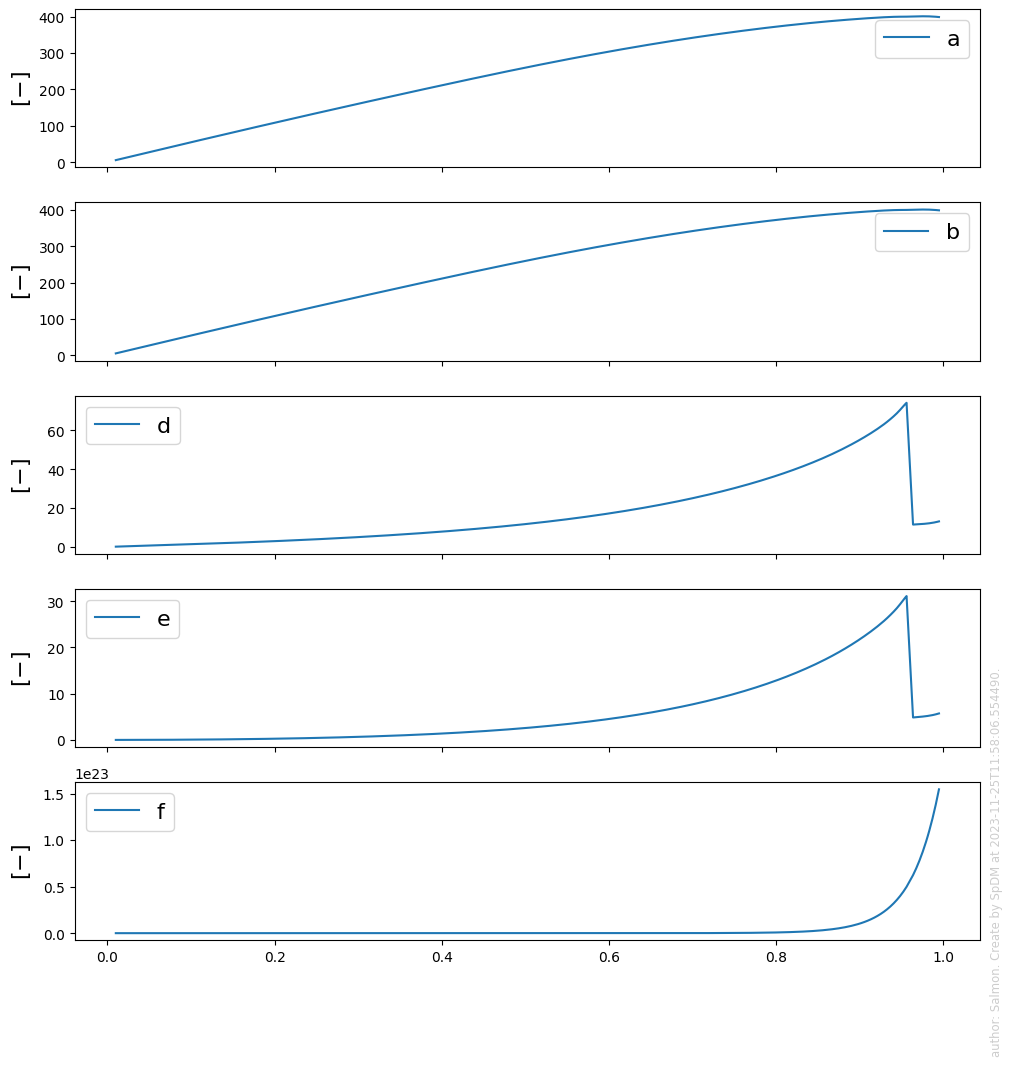

In [8]:
vars = sum([[equ.primary_quantity.profile, equ.primary_quantity.flux] for equ in solver_1d.equation], [])
equ = solver_1d.equation[0]
*_, (a, b, c, d, e, f, g) = equ.coefficient
x = solver_1d.grid.rho_tor_norm
# y = equ.primary_quantity.profile
# yp = equ.primary_quantity.d_dr
# flux = equ.primary_quantity.flux
# dflux = equ.primary_quantity.dflux_dr
fig = sp_view.plot(
    [
        (a(x,*vars), "a"),
        (b(x,*vars), "b"),
        # (c(x,*vars), "c"),
        (d(x, *vars), "d"),
        (e(x, *vars), "e"),
        (f(x, *vars), "f"),
        #(g(x, *vars), "g"),
        # [
        #     (d*yp, "$D$"),
        #     (e*y,   "$v$"),
        #     # (flux,   f"$\Gamma$"),
        #     ((c*(f - g * y)).I, r"$S$"),  # $\int c*(f - g \cdot y)$
        #     # ((-d*yp+e*y).I, r"$\Gamma$"),
        #     (-d*yp+e*y-(c*(f - g * y)).I, "residual"),
        # ],
        # y, yp
        # [
        #     (dflux, {"label": r"$d\Gamma$"}),
        #     # (Function(flux, x).d(), r"$d\Gamma$"),
        #     ((c*(f - g * y)), r"$c*(f - g \cdot y)$"),
        # ],
    ],
    x_axis=x,
)